In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf
from datetime import datetime

In [ ]:
# Fetch Stock Data

ticker = 'AAPL'
lookback = 60  # past 60 days to predict next day

df = yf.download(ticker, start='2018-01-01', end=datetime.now().strftime('%Y-%m-%d'))

# Optional: add simple moving average
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()
df.dropna(inplace=True)

# Scale Data

features = ['Close', 'MA_20', 'MA_50']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features])

/var/folders/wk/485j8zms4wx1g2b_h5h_gxn80000gn/T/ipykernel_66722/1275908725.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2018-01-01', end=datetime.now().strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed


In [ ]:

#  Prepare Sequences

X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i])
    y.append(scaled_data[i, 0])  # predict 'Close'

X, y = np.array(X), np.array(y)

# Split into train/test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:

# 4️ Build Vanilla LSTM Model

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

/Users/owner/Desktop/deep-learning/deep_learning/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 100)        │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,101 (285.55 KB)

 Trainable params: 73,101 (285.55 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:


history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0081 - mae: 0.0576 - val_loss: 0.0012 - val_mae: 0.0286
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0024 - mae: 0.0350 - val_loss: 0.0046 - val_mae: 0.0626
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0020 - mae: 0.0315 - val_loss: 0.0011 - val_mae: 0.0270
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017 - mae: 0.0293 - val_loss: 0.0041 - val_mae: 0.0589
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015 - mae: 0.0273 - val_loss: 0.0017 - val_mae: 0.0348
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014 - mae: 0.0260 - val_loss: 4.8656e-04 - val_mae: 0.0182
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014 - mae: 0.0262 - val_loss: 0.0016 - val_mae: 0.0353
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012 - mae: 0.0241 - val_loss: 4.7857e-04 - val_mae: 0.0177
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - los

In [ ]:

# Inverse transform
def inverse_transform(pred, scaler):
    temp = np.zeros((len(pred), scaler.n_features_in_))
    temp[:, 0] = pred.flatten()
    return scaler.inverse_transform(temp)[:, 0]

y_train_inv = inverse_transform(y_train, scaler)
train_pred_inv = inverse_transform(train_pred, scaler)
y_test_inv = inverse_transform(y_test, scaler)
test_pred_inv = inverse_transform(test_pred, scaler)

print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train_inv, train_pred_inv)):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test_inv, test_pred_inv)):.2f}")

/var/folders/wk/485j8zms4wx1g2b_h5h_gxn80000gn/T/ipykernel_66722/4052183827.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2018-01-01', end=datetime.now().strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed
/Users/owner/Desktop/deep-learning/deep_learning/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,101 (285.55 KB)

 Trainable params: 73,101 (285.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0116 - mae: 0.0690 - val_loss: 0.0010 - val_mae: 0.0273
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0023 - mae: 0.0338 - val_loss: 0.0011 - val_mae: 0.0271
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0019 - mae: 0.0313 - val_loss: 0.0054 - val_mae: 0.0682
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0017 - mae: 0.0293 - val_loss: 0.0029 - val_mae: 0.0479
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - mae: 0.0275 - val_loss: 0.0045 - val_mae: 0.0626
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - mae: 0.0270 - val_loss: 0.0029 - val_mae: 0.0490
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - mae: 0.0253 - val_loss: 0.0092 - val_mae: 0.0932
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014 - mae: 0.0267 - val_loss: 0.0032 - val_mae: 0.0520
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.001

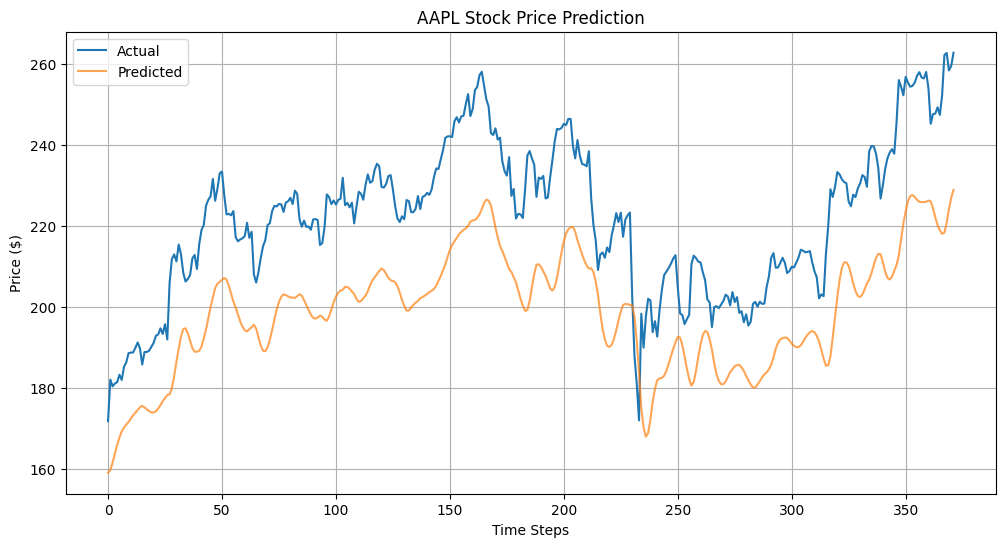

In [ ]:



# 7️⃣ Plot Results

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(test_pred_inv, label='Predicted', alpha=0.7)
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

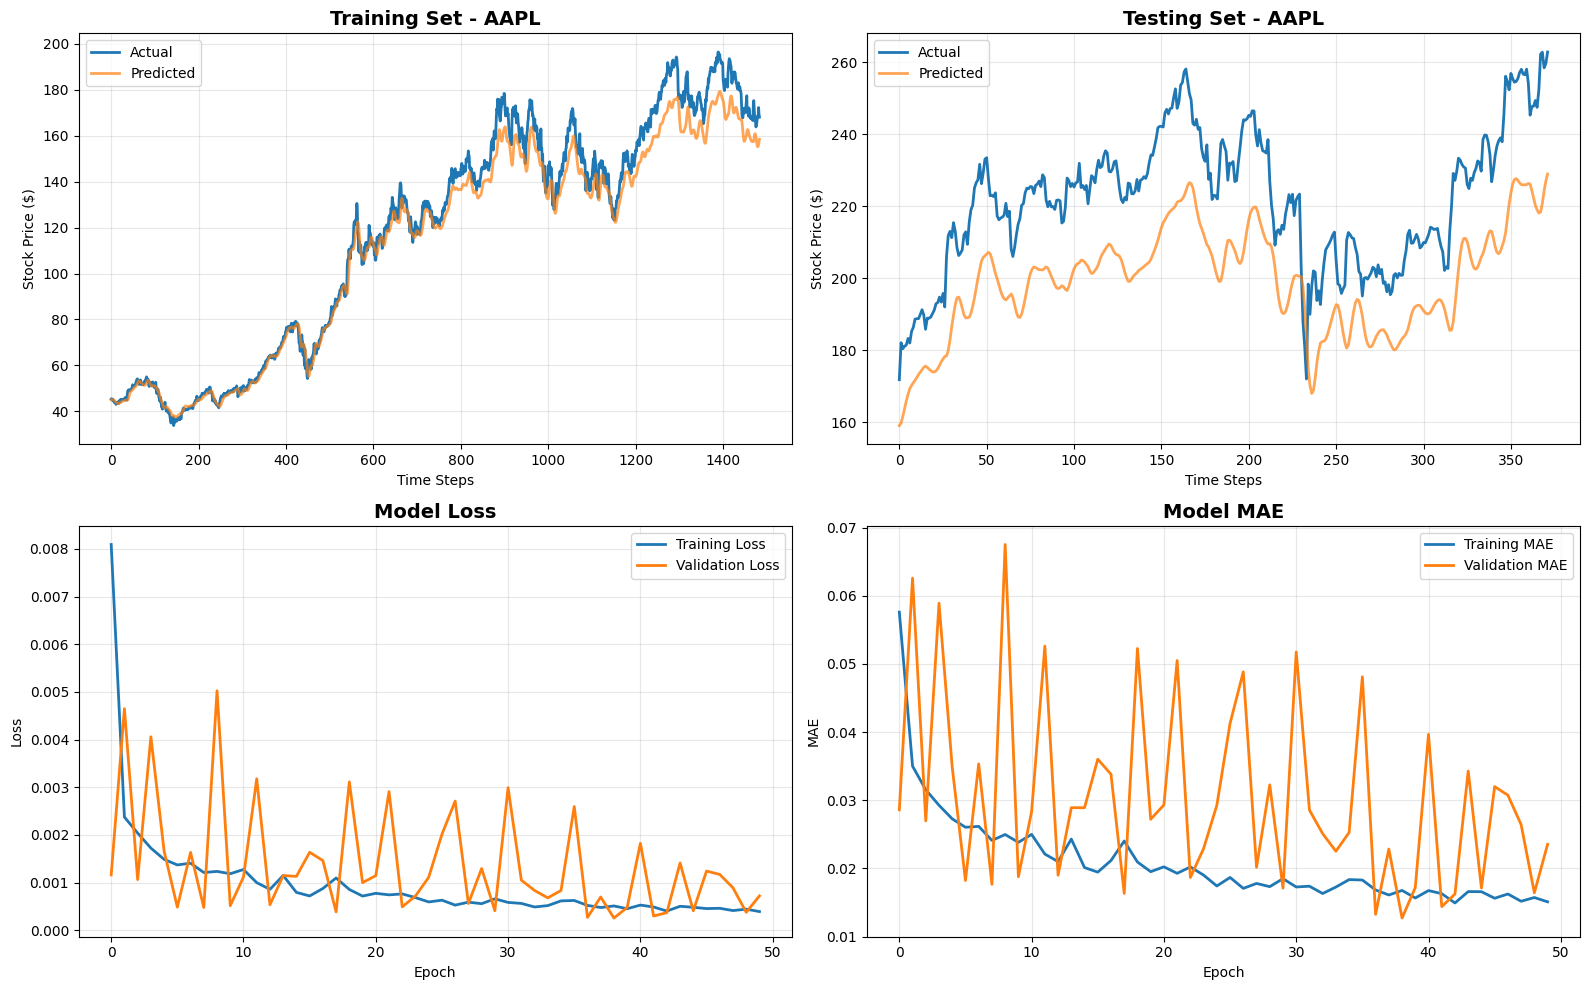

In [9]:
# Plot predictions vs actual
def plot_results(y_train, train_pred, y_test, test_pred, history):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Training predictions
    axes[0, 0].plot(y_train, label='Actual', linewidth=2)
    axes[0, 0].plot(train_pred, label='Predicted', linewidth=2, alpha=0.7)
    axes[0, 0].set_title('Training Set - AAPL', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Time Steps')
    axes[0, 0].set_ylabel('Stock Price ($)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Testing predictions
    axes[0, 1].plot(y_test, label='Actual', linewidth=2)
    axes[0, 1].plot(test_pred, label='Predicted', linewidth=2, alpha=0.7)
    axes[0, 1].set_title('Testing Set - AAPL', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Time Steps')
    axes[0, 1].set_ylabel('Stock Price ($)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Loss curve
    axes[1, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[1, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # MAE curve
    axes[1, 1].plot(history.history['mae'], label='Training MAE', linewidth=2)
    axes[1, 1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    axes[1, 1].set_title('Model MAE', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('MAE')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Usage after training and evaluation:
plot_results(y_train_inv, train_pred_inv, y_test_inv, test_pred_inv, history)